# Implementation of FedAvg with PyTorch on IID Data

## Section 0. Libraries and Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random
import math
from matplotlib import pyplot
from pathlib import Path
import requests
import pickle
import gzip
import torch
import math
import torch.nn.functional as F
from torch import nn
import urllib
import urllib
from pathlib import Path
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
pd.options.display.float_format = "{:,.4f}".format

## Section 1. Data Loading

In [2]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)
FILENAME = "mnist.pkl.gz"

In [3]:
with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")

In [4]:
# Let's see the dataset size
x_train.shape, y_train.shape , x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((50000, 784), (50000,), (10000, 784), (10000,), (10000, 784), (10000,))

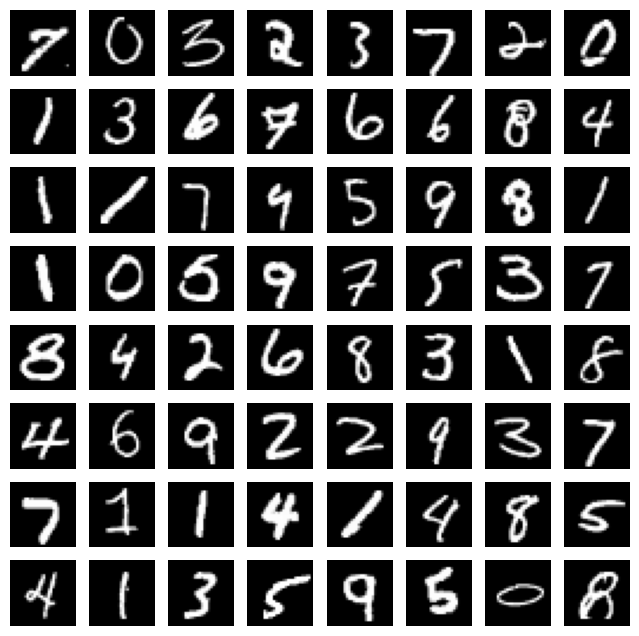

In [5]:
fig, axes = pyplot.subplots(8,8,figsize=(8,8))
for i in range(8):
    for j in range(8):
        num_index = np.random.randint(len(x_train))
        axes[i,j].imshow(x_train[num_index].reshape((28,28)), cmap="gray")
        axes[i,j].axis("off")
pyplot.show() 

### Here we can check how many of each tag are

In [6]:
# Let's check how many of each tag are.
y_train_total=0
y_valid_total=0
y_test_total=0
total=0
for i in range(10):
    print(i,">> train:", sum(y_train==i), ", valid:", sum(y_valid==i), 
          ", test:", sum(y_test==i), ", total:", sum(y_train==i)+sum(y_valid==i)+sum(y_test==i) )
    y_train_total=y_train_total + sum(y_train==i)
    y_valid_total=y_valid_total + sum(y_valid==i)
    y_test_total=y_test_total + sum(y_test==i)
    total=total+sum(y_train==i)+sum(y_valid==i)+sum(y_test==i)
    
print("y_train_total=", y_train_total) 
print("y_valid_total=", y_valid_total) 
print("y_test_total=", y_test_total)
print("total=", total)

0 >> train: 4932 , valid: 991 , test: 980 , total: 6903
1 >> train: 5678 , valid: 1064 , test: 1135 , total: 7877
2 >> train: 4968 , valid: 990 , test: 1032 , total: 6990
3 >> train: 5101 , valid: 1030 , test: 1010 , total: 7141
4 >> train: 4859 , valid: 983 , test: 982 , total: 6824
5 >> train: 4506 , valid: 915 , test: 892 , total: 6313
6 >> train: 4951 , valid: 967 , test: 958 , total: 6876
7 >> train: 5175 , valid: 1090 , test: 1028 , total: 7293
8 >> train: 4842 , valid: 1009 , test: 974 , total: 6825
9 >> train: 4988 , valid: 961 , test: 1009 , total: 6958
y_train_total= 50000
y_valid_total= 10000
y_test_total= 10000
total= 70000


In [9]:
def shuffle_and_select_labels(data, seed, amount):
    df = pd.DataFrame(data, columns=["labels"])
    df["index"] = np.arange(len(df))
    selected_labels = {}
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(df))
    for i in range(10):
        label_name = "label_" + str(i)
        label_info = df[df["labels"] == i]
        selected_indices = shuffled_indices[label_info.index][:amount]
        selected_data = df.loc[selected_indices, ["labels", "index"]]
        selected_labels[label_name] = selected_data
    return selected_labels

In [8]:
def get_subsamples_indices(label_dict, number_of_samples, amount):
    sample_dict = {}
    batch_size = math.floor(amount / number_of_samples)
    for i in range(number_of_samples):
        sample_name = "sample" + str(i)
        sample_data = []
        for j in range(10):
            label_name = "label_" + str(j)
            label_info = label_dict[label_name]
            start_index = i * batch_size
            end_index = (i + 1) * batch_size
            sample_data.append(label_info[start_index:end_index])
        sample_data = pd.concat(sample_data, axis=0).reset_index(drop=True)
        sample_dict[sample_name] = sample_data
    return sample_dict

In [37]:
def create_iid_subsamples(sample_dict, x_data, y_data, x_name, y_name):
    x_data_dict = {}
    y_data_dict = {}
    for i in range(len(sample_dict)):
        xname = x_name + str(i)
        yname = y_name + str(i)
        sample_name = "sample" + str(i)
        sample_indices = sample_dict[sample_name]["index"].values
        sorted_indices = np.sort(sample_indices)
        x_info = x_data[sorted_indices, :]
        x_data_dict[xname] = x_info
        y_info = y_data[sorted_indices]
        y_data_dict[yname] = y_info
    return x_data_dict, y_data_dict

## Classification Model

In [10]:
class Net2nn(nn.Module):
    def __init__(self):
        super(Net2nn, self).__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [12]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0

    for data, target in train_loader:
        output = model(data)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
        

    return train_loss / len(train_loader), correct/len(train_loader.dataset)

In [13]:
def validation(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            
            test_loss += criterion(output, target).item()
            prediction = output.argmax(dim=1, keepdim=True)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    test_loss /= len(test_loader)
    correct /= len(test_loader.dataset)

    return (test_loss, correct)

### Let's examine what would the performance of the centralized model be if the data were not distributed to nodes at all? </span>   


In [23]:
centralized_model = Net2nn()
centralized_optimizer = torch.optim.SGD(centralized_model.parameters(), lr=0.01, momentum=0.9)
centralized_criterion = nn.CrossEntropyLoss()

In [24]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size * 2)

In [28]:
print("------ Centralized Model ------")
for epoch in range(numEpoch):
    central_train_loss, central_train_accuracy = train(centralized_model, train_dl, centralized_criterion, centralized_optimizer)
    central_test_loss, central_test_accuracy = validation(centralized_model, test_dl, centralized_criterion)
    
    print("epoch: {:3.0f}".format(epoch+1) + " | train accuracy: {:7.4f}".format(central_train_accuracy) + " | test accuracy: {:7.4f}".format(central_test_accuracy))

print("------ Training finished ------")

------ Centralized Model ------
epoch:   1 | train accuracy:  0.8752 | test accuracy:  0.9530
epoch:   2 | train accuracy:  0.9560 | test accuracy:  0.9596
epoch:   3 | train accuracy:  0.9706 | test accuracy:  0.9699
epoch:   4 | train accuracy:  0.9784 | test accuracy:  0.9686
epoch:   5 | train accuracy:  0.9825 | test accuracy:  0.9718
epoch:   6 | train accuracy:  0.9869 | test accuracy:  0.9780
epoch:   7 | train accuracy:  0.9893 | test accuracy:  0.9785
epoch:   8 | train accuracy:  0.9921 | test accuracy:  0.9777
epoch:   9 | train accuracy:  0.9939 | test accuracy:  0.9765
epoch:  10 | train accuracy:  0.9947 | test accuracy:  0.9787
------ Training finished ------
